<a href="https://colab.research.google.com/github/andrav15/Clasificator/blob/main/Clasificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision #pentru seturi de date de imagine
import torchvision.transforms as transforms #pentru diferite transformari pe imagine

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#Compose combina o serie de transformari intr-una singura;toate transf vor fi aplicate in ordinea enumerata
#ToTensor numpy->tensor pytorch
#Normalize normalizeaza tensorii: prima tupla:media pe R,G,B, a 2-a:deviatia standard
batch_size = 4#modelul va procesa cate 4 imag in acelasi timp

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
#incarca setul de date specif directorul si aplic transf definite mai sus pe fiecare imag
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
#DataLoader care permite sa iteram prin set; num_workers=nr de procese folosite pt a incarca date

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
#denumirile claselor din set-etichetele

100%|██████████| 170M/170M [00:02<00:00, 57.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


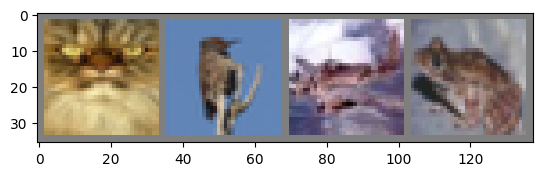

cat   bird  plane frog 


In [4]:
import matplotlib.pyplot as plt#pt grafice
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5 #mai sus am normalizat-o acum revenim la original pt a fi afisate corect
    npimg = img.numpy() #convertim tensorul in numpy pt a folosi fct matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #afisam imag si schimbam ordinea CHW->HWC, C=nr de canale RGB, H=inaltimea,W=latimea
    plt.show() #afisare


# get some random training images
dataiter = iter(trainloader)#pt a accesa loturi de imag si etichete
images, labels = next(dataiter) #images-tensori,labels-etichetele

# show images
imshow(torchvision.utils.make_grid(images))#combina mai multe imag intr-una pt a fi afisate mai usor
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))#formam un sir de caractere care contine denumirile claselor;
#fiecare cls va ocupa un spatiu de 5 caractere pt aliniere

In [5]:
import torch.nn as nn #nn un submodul pt retele neuronale predefinite
import torch.nn.functional as F #fct aplicate in mod functional la tensori


class Net(nn.Module):
    def __init__(self): #metoda constructor
        super().__init__()#apeleaza constr clasei parinte
        self.conv1 = nn.Conv2d(3, 6, 5)#primul strat convolutional: 3 canale RGB, 6 filtre, kernel 5x5
        self.pool = nn.MaxPool2d(2, 2)#strat max pooling:reduce dim imag: kernel 2x2, pasul 2 cu care se aplica pooling->2pixeli
        self.conv2 = nn.Conv2d(6, 16, 5)#strat conv 2: 6 canale RGB, 16 filtre, kernel 5x5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)#primul strat fully connected
        #16*5*5 nr de neuroni de intrare->16 filtr fiecare cu dim 5x5 de mai sus
        #120 nr de neuroni out
        self.fc2 = nn.Linear(120, 84)#al doilea strat fully connected: 120 neuroni in si 84 out
        self.fc3 = nn.Linear(84, 10)#ultimul fully connected: 84 in si 10 out->10 clase

    def forward(self, x):#o apelam mereu cand exista o predictie
        x = self.pool(F.relu(self.conv1(x)))#aplicam stratul conv la inputul x, urmat de fct relu si max pooling->extragere caract
        x = self.pool(F.relu(self.conv2(x))) #similar
        x = torch.flatten(x, 1) #aplatizam tensorul x 2D->1D, batch 1 adica vrem sa pastram dim initiala
        x = F.relu(self.fc1(x))#apl primul strat fully connected urmat de relu
        x = F.relu(self.fc2(x))
        x = self.fc3(x)#produce iesirile pt cele 10 cls, nu aplicam relu pt ca vrem scoruri brute
        return x


net = Net()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() #fct de pierdere:penalizeaza modelul si-l ajuta sa invete mai eficient
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#SGD=Stochastic Gradient Descent
#preia param si le actualizeaza in timpul antrenarii
#lr learning rate:cat de mult sa fie ajustate greutatile la fiecare pas(lr prea mare->divergenta, lr prea mic->converge lent)
#momentum accelereaza procesul unde gradientul este cst

In [7]:
for epoch in range(2):  # 2 epoci. o epoca=o completare a trecerii prin intregul set

    running_loss = 0.0#pt calcularea mediei pierderii
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data#inputs-imag, labels-etichete

        # zero the parameter gradients
        optimizer.zero_grad()#fara linia asta gradientele s-ar acumula in fiecare iteratie->actualizari gresite

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)#compara outputs cu etichetele si returneaza loss
        loss.backward()#propagarea inapoi pt a calcula gradientele pierderii
        optimizer.step()

        # print statistics
        running_loss += loss.item()#add val pierderii curente  si item extrage val in tensor
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.232
[1,  4000] loss: 1.854
[1,  6000] loss: 1.679
[1,  8000] loss: 1.575
[1, 10000] loss: 1.515
[1, 12000] loss: 1.483
[2,  2000] loss: 1.383
[2,  4000] loss: 1.373
[2,  6000] loss: 1.340
[2,  8000] loss: 1.305
[2, 10000] loss: 1.312
[2, 12000] loss: 1.287
Finished Training


In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)#return dictionar cu greutati si bias

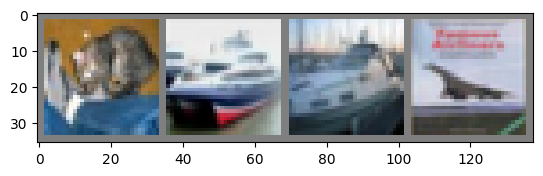

GroundTruth:  cat   ship  ship  plane


In [9]:
dataiter = iter(testloader)# permite iteratia prin set
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
# fct combina mai multe imag din images intr-o sg matrice pt a fi afisata mai usor
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [11]:
net = Net()#o noua instanta a clasei Net
net.load_state_dict(torch.load(PATH, weights_only=True))#incarca greutatile care au fost salvate anterior

<All keys matched successfully>

In [12]:
outputs = net(images)#trece imag prin model pt predictii->propagare inainte

In [13]:
_, predicted = torch.max(outputs, 1)#gaseste val max si indicii coresp de-a lungul dim=1
#predicted=indicele cls cu scorul max pt fiecare imag->cls prezisa de retea

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))#afisarea predicitiilor

Predicted:  cat   ship  ship  ship 


In [14]:
correct = 0#cate predictii corecte face modelul
total = 0#nr total de imag
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():#dezactiveaza calculul grad->reduce consumul de mem
    for data in testloader:#iteram prin intregul set de date.fiecare el contine un mini-lot de imag+etichetele lor
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)#propagarea inainte->obtine predictii brute
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)#cls cu val cea mai mare pt fiecare imag
        total += labels.size(0)#actualizam variabila total cu nr de imag curente
        correct += (predicted == labels).sum().item()#comparam predictiile cu etichetele reale.
        #predicted==labels->true sau false->sum aduna toate val true->adaugat in correct

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
#calc procentajul de imag clasificate corect

Accuracy of the network on the 10000 test images: 54 %


In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}#dict cu nr de predictii corecte.fiecare cls se initializeaza cu 0
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():#dezactivarea calculului gradientului pt ca nu mai antrenam
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):#combina etichetele realie si predictiile in perechi pt iterare simultana
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1#chiar daca predictia nu e corecta o adaugam in total


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 49.6 %
Accuracy for class: car   is 61.2 %
Accuracy for class: bird  is 25.4 %
Accuracy for class: cat   is 30.3 %
Accuracy for class: deer  is 45.7 %
Accuracy for class: dog   is 62.0 %
Accuracy for class: frog  is 61.6 %
Accuracy for class: horse is 66.7 %
Accuracy for class: ship  is 72.5 %
Accuracy for class: truck is 68.2 %


In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#verif aca exista un GPU compatibil cu CUDA
#daca exista->True->device='cuda=0'->primul disp GPU
#daca nu exista->False->device='cpu'->va rula pe procesor

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [17]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
inputs, labels = data[0].to(device), data[1].to(device)